In [83]:
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
from modules.Utils.utils import loadFromDB,strategyTester
from datetime import datetime

In [56]:
SYMBOL= 'BTC'
df = loadFromDB(SYMBOL,'1h').iloc[-13000:]
df.head()

,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2021-04-03 21:00:00,58054.16,58262.30,57500.00,57631.28,2312.683097,1617483600
2021-04-03 22:00:00,57631.28,57784.19,57088.27,57556.75,3075.478671,1617487200
2021-04-03 23:00:00,57556.76,57800.00,56880.00,57051.94,3656.809767,1617490800
2021-04-04 00:00:00,57051.95,57269.92,56507.91,56600.00,3651.491736,1617494400
2021-04-04 01:00:00,56600.00,57153.74,56388.00,56933.46,3526.290840,1617498000


In [57]:
import requests
response = requests.get(f'https://crypto-api.zlochteam.com/get-BTC-tweets').json()
print(f'{response["total"]} records in the dataset')

df_tweets = pd.DataFrame(response['data'])
df_tweets['Date'] = df_tweets['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tweets = df_tweets.set_index('Date')
df_tweets = df_tweets.sort_index(axis=0)
df_tweets.drop(columns=['timestamp'], inplace=True)
df_tweets.head()

18540 records in the dataset


,mean subjectivity,negative,neutral,positive,symbol
Date,,,,,
2022-05-27 16:50:38,0.372202,20.0,39,41,BTC
2022-05-27 17:00:39,0.292128,9.0,54,37,BTC
2022-05-27 17:10:40,0.342122,14.0,48,38,BTC
2022-05-27 17:20:40,0.360531,13.0,38,49,BTC
2022-05-27 17:30:41,0.263152,11.0,46,43,BTC


In [58]:
response = requests.get(f'https://crypto-api.zlochteam.com/get-trading-view-indicators').json()
print(f'{response["total"]} records in the dataset')

df_tvta = pd.DataFrame(response['data'])
df_tvta['Date'] = df_tvta['timestamp'].astype(int).apply(datetime.fromtimestamp)
df_tvta = df_tvta.set_index('Date')
df_tvta = df_tvta.sort_index(axis=0)
df_tvta.head()

183477 records in the dataset


,buy,neutral,sell,symbol,timestamp
Date,,,,,
2022-05-28 15:20:20,14,9,3,BTC,1653744020
2022-05-28 15:21:20,14,9,3,BTC,1653744080
2022-05-28 15:22:20,14,9,3,BTC,1653744140
2022-05-28 15:23:21,14,10,2,BTC,1653744201
2022-05-28 15:24:21,15,10,1,BTC,1653744261


In [59]:
df = df.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]

df_tweets = df_tweets.loc[pd.to_datetime(df_tvta.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]

df_tvta = df_tvta.loc[pd.to_datetime(df.iloc[0].name).date().strftime("%Y-%m-%d"):pd.to_datetime(df.iloc[-1].name).date().strftime("%Y-%m-%d")]

df.head()

,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2022-05-28 00:00:00,28629.81,28825.44,28558.24,28806.30,1875.59197,1653696000
2022-05-28 01:00:00,28806.30,28842.93,28450.00,28615.82,5775.34689,1653699600
2022-05-28 02:00:00,28615.83,28743.02,28598.43,28685.95,1288.08616,1653703200
2022-05-28 03:00:00,28685.94,28854.05,28630.81,28819.20,1787.27409,1653706800
2022-05-28 04:00:00,28819.20,28890.00,28754.40,28833.13,1362.65989,1653710400


In [76]:
def generateHourlyDataFormTweets(tweet_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tweet_df['join_key'] = tweet_df.apply(createJoinKey, axis=1)
    tweet_df = tweet_df.groupby(by='join_key',as_index=False,axis=0).agg({
        'mean subjectivity':'mean',
        'negative':'sum',
        'neutral':'sum',
        'positive':'sum'})

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tweet_df['Date']=tweet_df.apply(recreateDates, axis=1)
    tweet_df = tweet_df.set_index('Date').sort_index(axis=0)
    tweet_df['Sum'] = tweet_df.apply(lambda row: (row.positive+row.negative),axis=1)
    # tweet_df['Sum'] = tweet_df.apply(lambda row: (row.positive+row.neutral+row.negative),axis=1)
    tweet_df['negative'] = tweet_df.apply(lambda row: row.negative/(row.Sum),axis=1)
    tweet_df['neutral'] = tweet_df.apply(lambda row: row.neutral/(row.Sum),axis=1)
    tweet_df['positive'] = tweet_df.apply(lambda row: row.positive/(row.Sum),axis=1)
    return tweet_df.drop(columns=['join_key','Sum'])
    
df_tweets_houly = generateHourlyDataFormTweets(df_tweets)
df_tweets_houly

,mean subjectivity,negative,neutral,positive
Date,,,,
2022-05-28 00:00:00,0.301047,0.198795,0.807229,0.801205
2022-05-28 01:00:00,0.312384,0.233038,0.769912,0.766962
2022-05-28 02:00:00,0.332107,0.162602,0.626016,0.837398
2022-05-28 03:00:00,0.327784,0.209581,0.796407,0.790419
2022-05-28 04:00:00,0.349075,0.196629,0.682584,0.803371
...,...,...,...,...
2022-09-27 19:00:00,0.344565,0.195906,0.748538,0.804094
2022-09-27 20:00:00,0.298564,0.158683,0.790419,0.841317
2022-09-27 21:00:00,0.333901,0.175953,0.759531,0.824047


In [77]:
def generateHourlyDataFormTVTA(tvta_df):
    def createJoinKey(x):
        return pd.to_datetime(x.name).date().strftime("%Y%m%d")+pd.to_datetime(x.name).strftime("%H")

    tvta_df['join_key'] = tvta_df.apply(createJoinKey, axis=1)
    tvta_df = tvta_df.groupby(by='join_key',as_index=False,axis=0).sum()

    def recreateDates(x):
        date_str = x.join_key
        year = date_str[:4]
        month= date_str[4:6]
        day= date_str[6:8]
        hour= date_str[8:10]
        return datetime.strptime( f'{year}-{month}-{day} {hour}:00:00', '%Y-%m-%d %H:%M:%S')

    tvta_df['Date']=tvta_df.apply(recreateDates, axis=1)
    tvta_df = tvta_df.set_index('Date').sort_index(axis=0)
    tvta_df['Sum'] = tvta_df.apply(lambda row: (row.buy+row.sell),axis=1)
    #tvta_df['Sum'] = tvta_df.apply(lambda row: (row.buy+row.neutral+row.sell),axis=1)
    tvta_df['buy'] = tvta_df.apply(lambda row: row.buy/(row.Sum),axis=1)
    tvta_df['neutral'] = tvta_df.apply(lambda row: row.neutral/(row.Sum),axis=1)
    tvta_df['sell'] = tvta_df.apply(lambda row: row.sell/(row.Sum),axis=1)
    return tvta_df.drop(columns=['join_key','timestamp','Sum'])
    
df_tvta_hourly = generateHourlyDataFormTVTA(df_tvta)
df_tvta_hourly

/tmp/ipykernel_13979/202087238.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tvta_df = tvta_df.groupby(by='join_key',as_index=False,axis=0).sum()


,buy,neutral,sell
Date,,,
2022-05-28 15:00:00,0.631501,0.545319,0.368499
2022-05-28 16:00:00,0.385913,0.547619,0.614087
2022-05-28 17:00:00,0.517544,0.520468,0.482456
2022-05-28 18:00:00,0.437562,0.532468,0.562438
2022-05-28 19:00:00,0.265226,0.532417,0.734774
...,...,...,...
2022-09-27 19:00:00,0.239000,0.560000,0.761000
2022-09-27 20:00:00,0.514563,0.514563,0.485437
2022-09-27 21:00:00,0.474308,0.541502,0.525692


In [104]:
df_merged = pd.merge(df, df_tweets_houly, how='inner', left_index=True, right_index=True)
df_merged.drop(columns=['neutral'], inplace=True)
df_merged = pd.merge(df_merged, df_tvta_hourly, how='inner', left_index=True, right_index=True)
df_merged.drop(columns=['neutral'], inplace=True)
df_merged = df_merged[['Open','High','Low','Close','Volume','mean subjectivity','negative','positive','buy','sell']]
df_merged.rename(columns = {'mean subjectivity':'Subjectivity',
                     'negative':'Twitter_negative',
                     'positive':'Twitter_positive',
                     'buy':'TV_buy',
                      'sell':'TV_sell'}, inplace = True)
df_merged

,Open,High,Low,Close,Volume,Subjectivity,Twitter_negative,Twitter_positive,TV_buy,TV_sell
Date,,,,,,,,,,
2022-05-28 15:00:00,28957.23,29089.32,28890.00,28988.21,1372.67136,0.318931,0.124011,0.875989,0.631501,0.368499
2022-05-28 16:00:00,28988.20,29050.00,28902.84,28907.50,1084.13049,0.385139,0.121212,0.878788,0.385913,0.614087
2022-05-28 17:00:00,28907.50,29030.00,28784.48,28886.61,2238.88338,0.372194,0.212766,0.787234,0.517544,0.482456
2022-05-28 18:00:00,28886.61,29019.16,28886.60,29001.74,599.37685,0.366971,0.143590,0.856410,0.437562,0.562438
2022-05-28 19:00:00,29001.74,29067.01,28943.03,29019.82,665.98027,0.322691,0.166197,0.833803,0.265226,0.734774
...,...,...,...,...,...,...,...,...,...,...
2022-09-27 08:00:00,20183.74,20229.28,20105.28,20145.81,19838.22310,0.335655,0.095238,0.904762,0.636272,0.363728
2022-09-27 09:00:00,20146.73,20219.83,20091.30,20182.53,21878.98969,0.308447,0.122283,0.877717,0.554563,0.445437
2022-09-27 10:00:00,20181.62,20283.09,20177.97,20221.67,19506.29629,0.326708,0.156250,0.843750,0.322677,0.677323


In [94]:
df_merged['Twitter_negative_EMA'] = df_merged['Twitter_negative'].ewm(span=20, adjust=False).mean()
df_merged['Twitter_positive_EMA'] = df_merged['Twitter_positive'].ewm(span=20, adjust=False).mean()
df_merged['TV_buy_EMA'] = df_merged['TV_buy'].ewm(span=20, adjust=False).mean()
df_merged['TV_sell_EMA'] = df_merged['TV_sell'].ewm(span=20, adjust=False).mean()

def zscore(series,lookback):
    return (series - series.rolling(lookback).mean()) / series.rolling(lookback).std()

df_merged['Close_normalized'] = zscore(df_merged['Close'],20)

<AxesSubplot: >

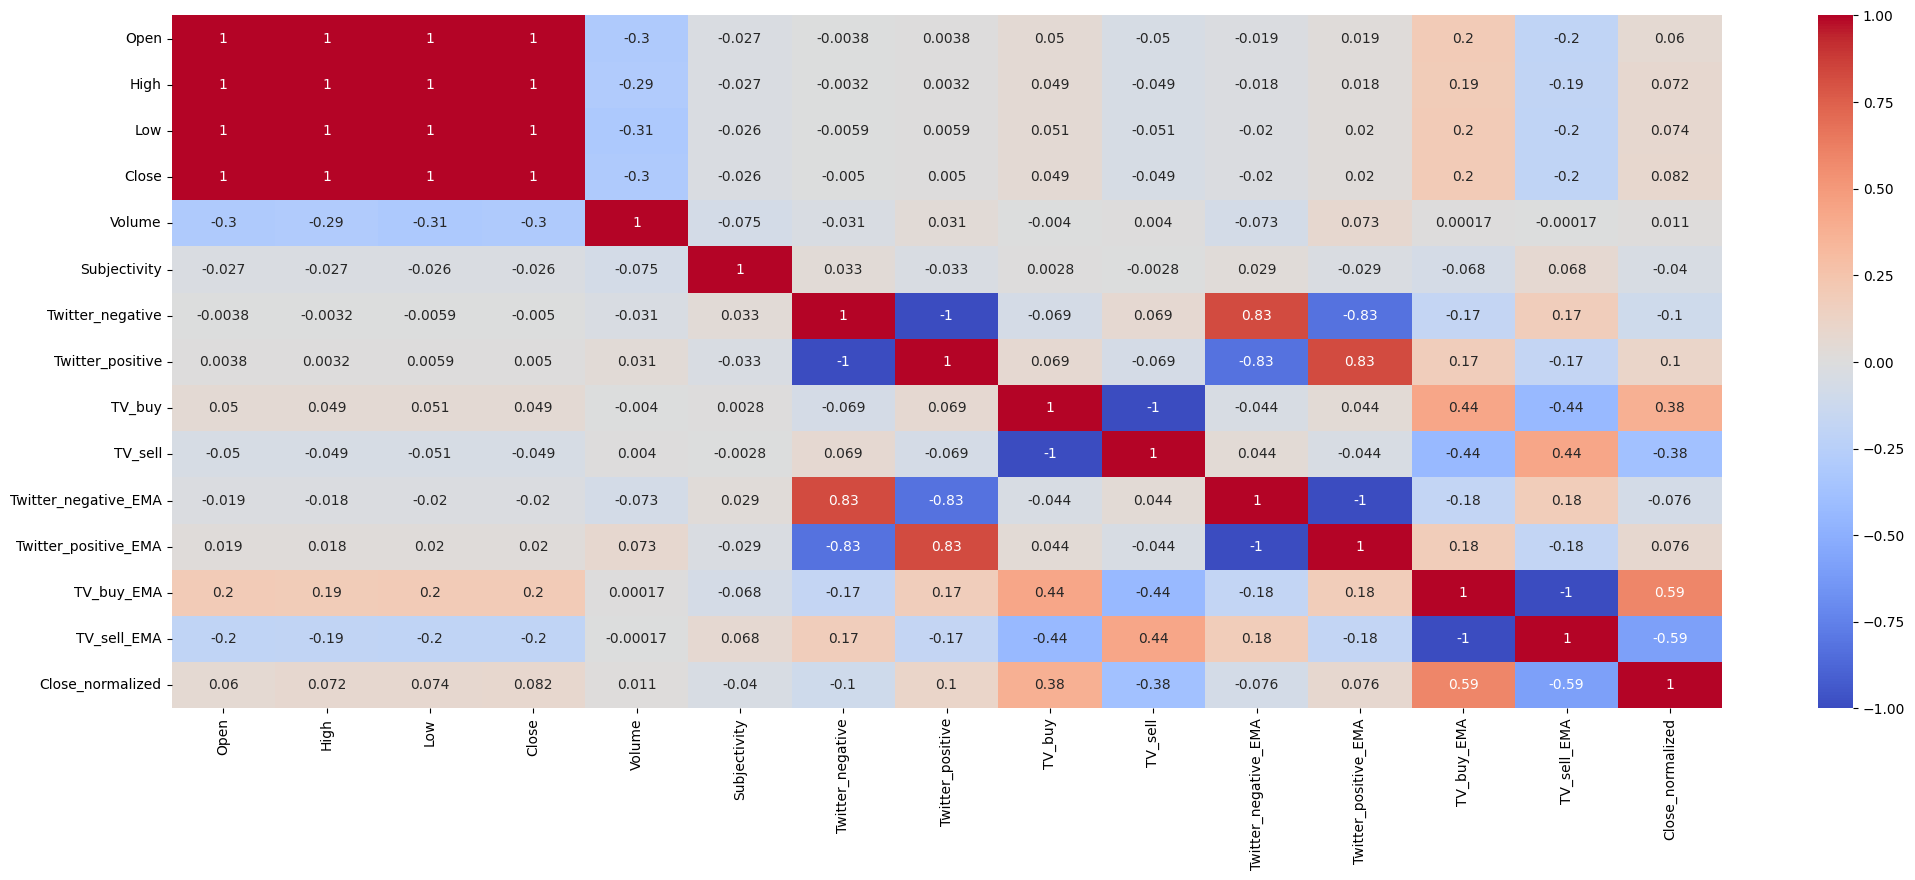

In [95]:
# plot the heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(25,9))
import seaborn as sns

sns.heatmap(df_merged.corr(), annot=True, cmap='coolwarm',
        xticklabels=df_merged.columns,
        yticklabels=df_merged.columns,ax=ax)

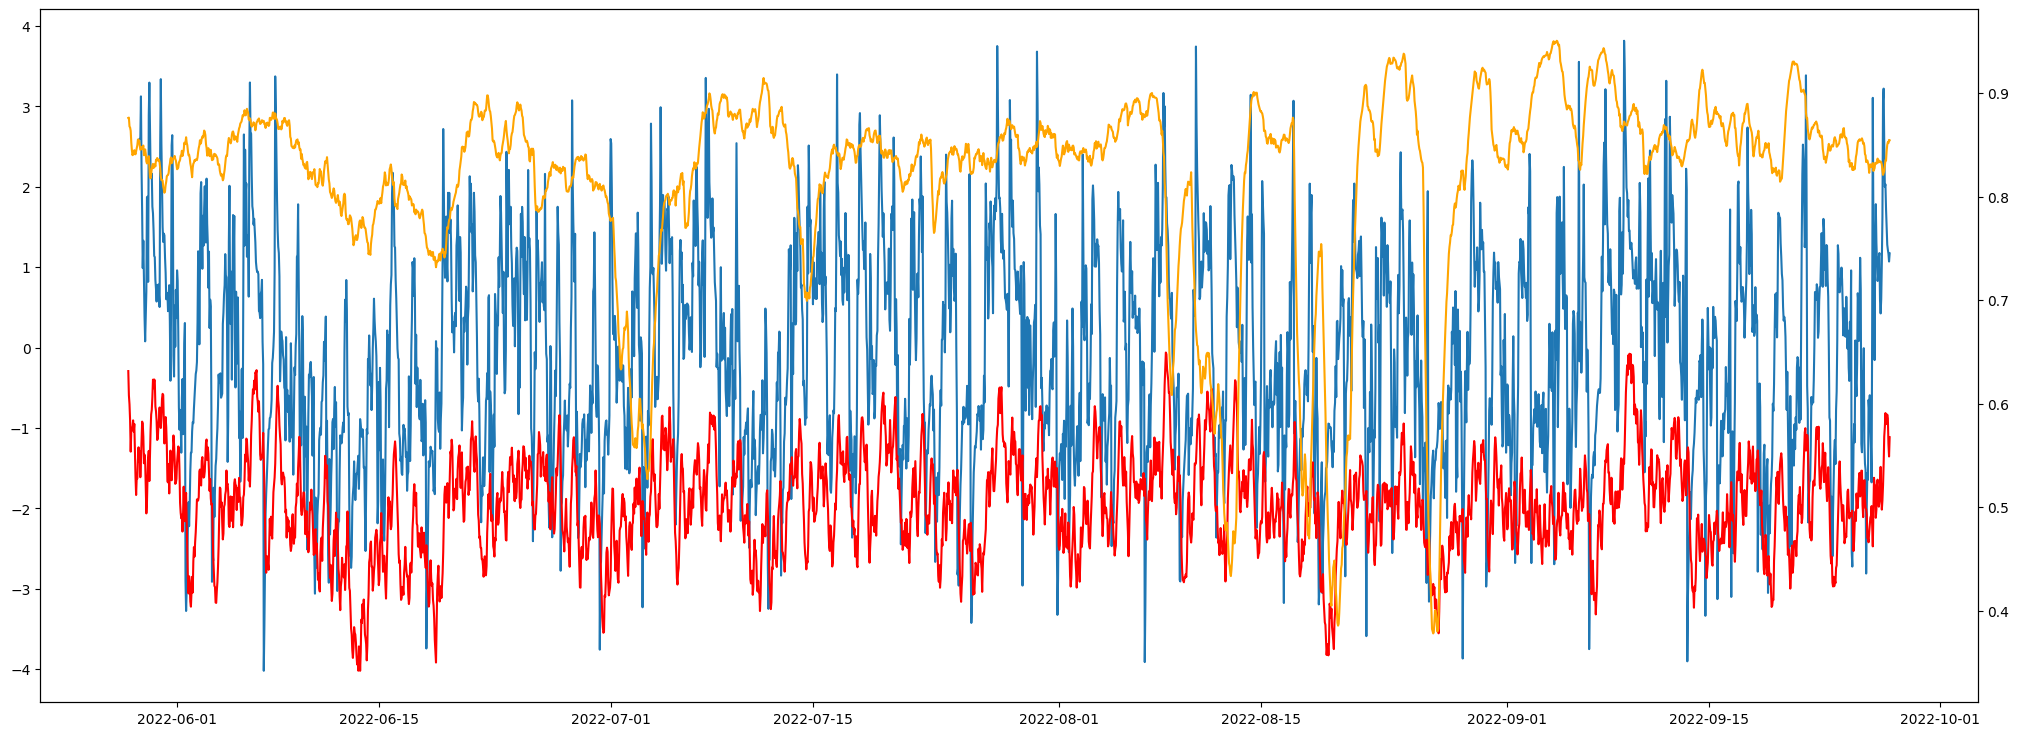

In [96]:
fig, ax = plt.subplots(1, figsize=(25,9))

ax.plot(df_merged.index, df_merged['Close_normalized'], label='Close')
ax_2 = ax.twinx()
ax_2.plot(df_merged.index, df_merged['TV_buy_EMA'], label='TV_buy', color='red')
ax_2.plot(df_merged.index, df_merged['Twitter_positive_EMA'], label='Twitter_positive', color='orange')

Period : [2022-05-28 15:00:00] -> [2022-09-27 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 877.73 $
Performance vs US Dollar : -12.23 %
Buy and Hold Performence : -29.83 %
Performance vs Buy and Hold : -59.01 %
Best trade : +0.75 %, the 2022-08-26 14:00:00
Worst trade : -8.74 %, the 2022-08-19 15:00:00
Worst drawBack : -13.0 %
Total fees :  4.49 $

----- Trades Informations -----
Total trades on period : 3
Number of positive trades : 1
Number of negative trades :  2
Trades win rate ratio : 33.33 %
Average trades performance : -4.09 %
Average positive trades : 0.75 %
Average negative trades : -6.5 %

----- Plot -----


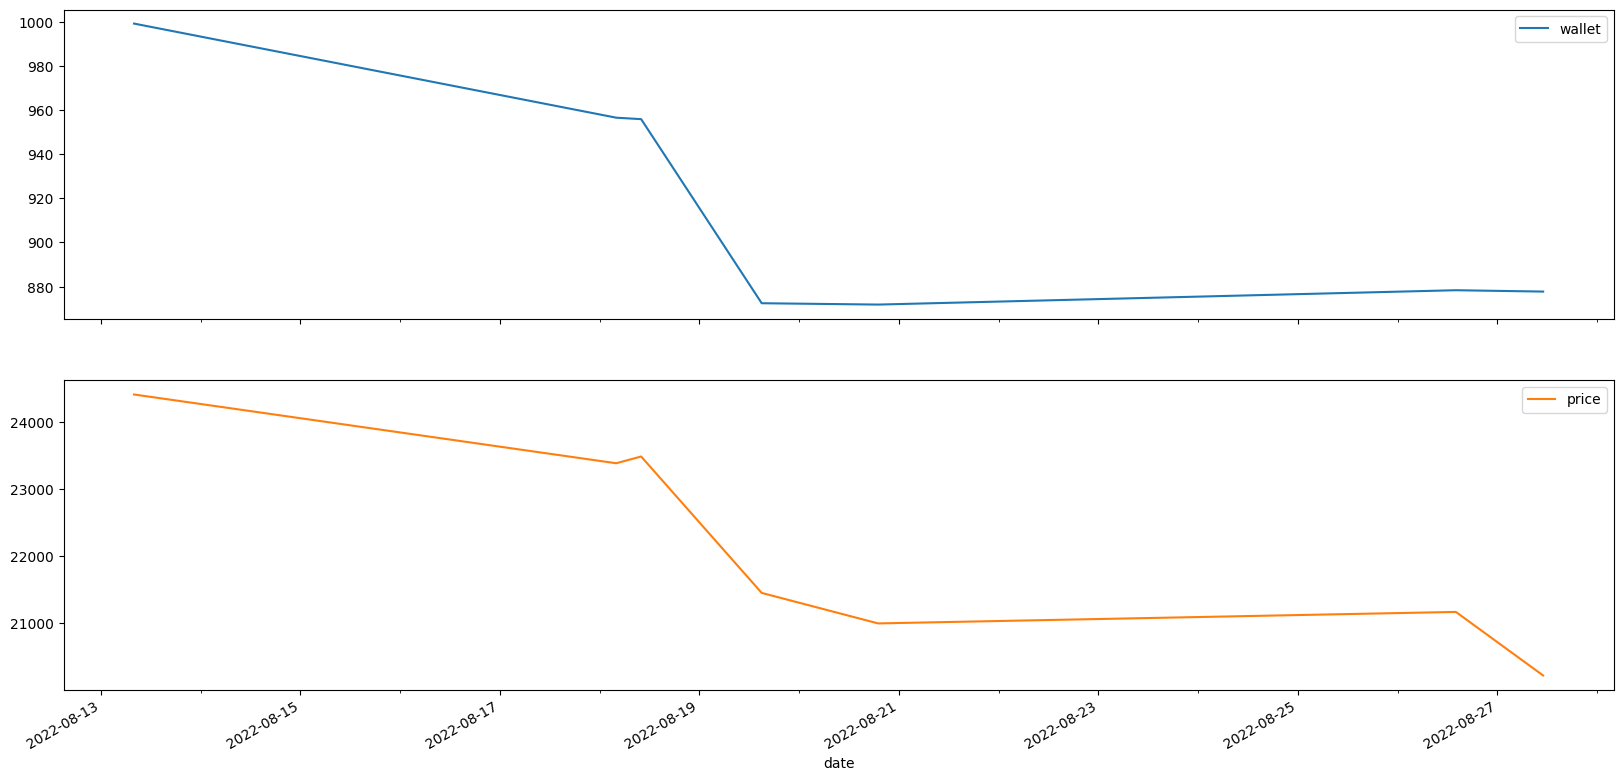

In [98]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row.Twitter_positive_EMA>0.5 and
                    previous_row.Twitter_positive_EMA<0.5)else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row.Twitter_negative_EMA>0.5 and
                    previous_row.Twitter_negative_EMA<0.5) else False

strategyTester(df_merged,buyCondition,sellCondition,equity=1000)

In [119]:
import numpy as np
results= []
df_merged_test = df_merged.copy()

def zscore(series,lookback):
    return (series - series.rolling(lookback).mean()) / series.rolling(lookback).std()

for i in range(5,80,5):    
    for j in range(5,80,5):
       # for k in range(2,20,2):        Twitter_positive_EMA
            df_merged_test = df_merged.copy()   
            df_merged_test['Twitter_positive_EMA'] = df_merged_test['Twitter_positive'].ewm(span=j, adjust=False).mean()
        
            df_merged_test['Close_normalized'] = zscore(df_merged_test['Close'],i)
            df_merged_test.dropna(inplace=True)
            
            correlation_coef = np.corrcoef(df_merged_test.Twitter_positive_EMA,df_merged_test.Close_normalized)[0,1]
            result = {'Rolling_Scaler':i,'TV_MA':j,'correlation':correlation_coef}
            results.append(result)
            
result_df = pd.DataFrame(results)
result_df.sort_values(by='correlation',ascending=False,inplace=True)
result_df

,Rolling_Scaler,TV_MA,correlation
135,50,5,0.182468
120,45,5,0.181378
150,55,5,0.177301
136,50,10,0.173928
105,40,5,0.173154
...,...,...,...
10,5,55,0.026320
11,5,60,0.024847
12,5,65,0.023531
13,5,70,0.022368


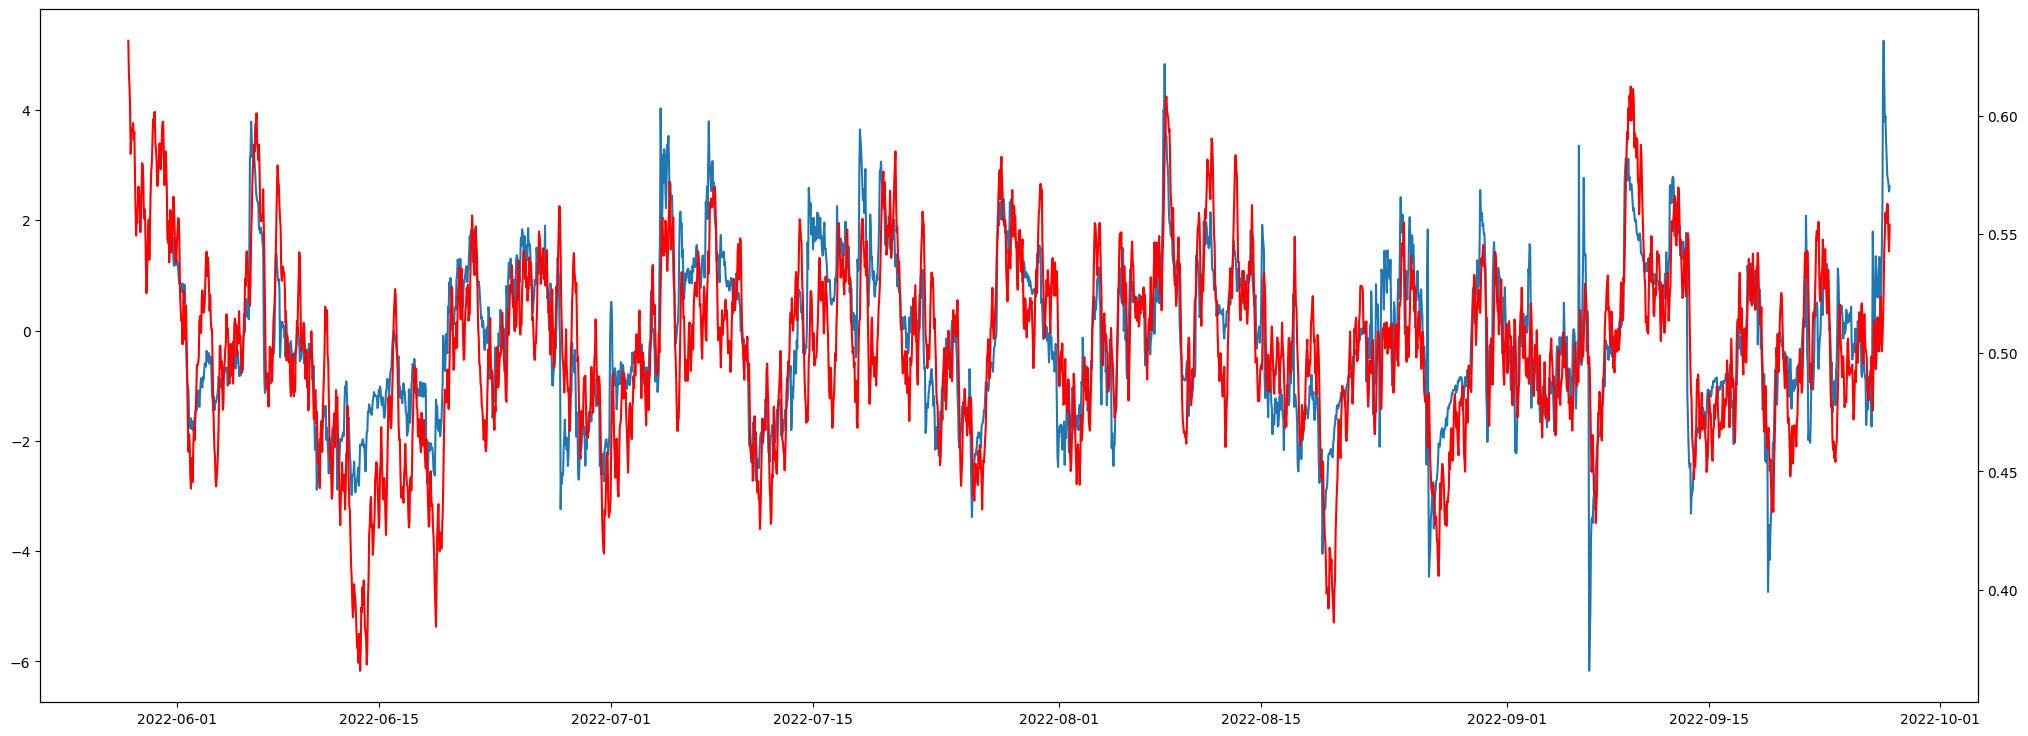

In [121]:
fig, ax = plt.subplots(1, figsize=(25,9))

df_merged_test = df_merged.copy()
df_merged_test['TV_buy_EMA'] = df_merged_test['TV_buy'].ewm(span=35, adjust=False).mean()

df_merged_test['Close_normalized'] = zscore(df_merged_test['Close'],75)
ax.plot(df_merged_test.index, df_merged_test['Close_normalized'], label='Close')
ax_2 = ax.twinx()
ax_2.plot(df_merged_test.index, df_merged_test['TV_buy_EMA'], label='TV_buy', color='red')